## Imports and Config

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import geopandas as gpd

In [2]:
%matplotlib inline
pd.set_option('max_columns', 50)
from jupyterthemes import jtplot
jtplot.style(grid=False, figsize=(10, 10))

In [ ]:
from tts_data import TTSData
from traffic_regions import TrafficRegions
from simulation_net import SimulationNet
from region_graph import RegionGraph

## Loading Data

### Loading simulation network

In [4]:
osm_path = 'data/osm_to_sumo/osm.net.xml'
sim_net = SimulationNet(osm_path)

Internal: 1300 | External: 388
Terminal : 75 | Pruned: 313


### Loading Toronto Transportation Survey (TTS) Data

In [5]:
tts_path = 'data/tts_data/tts_alltrips.txt'
tts_savedir = 'data/tts_data'
tts_data = TTSData(tts_path, tts_savedir)

### Loading traffic regions used in TTS and highways

#### Traffic Zones
Uses the 2006 TTS traffic zones as defined at http://dmg.utoronto.ca/survey-boundary-files#2006_zone <br/><br/> 

#### Planning Districts
Uses the planning district and regional boundaries as defined at http://dmg.utoronto.ca/survey-boundary-files#pd <br/><br/> 

#### Highways 
Uses the Ontario Road Network classification of Freeway, Highway/Expressway to determine highways for inter-regional travel.

For details about the ORN dataset used:
https://geohub.lio.gov.on.ca/datasets/923cb3294384488e8a4ffbeb3b8f6cb2_32 <br>
For details about the attributes: <br>
https://docs.ontario.ca/documents/1866/go-its-29-ontario-road-network-orn.pdf


In [65]:
taz_shape_path = 'data/tts_data/tts_traffic_zones/tts06_83_region.shp'
pd_shape_path = 'data/tts_data/tts_planning_districts/tts06_pd_83.shp'
orn_path = 'data/ontario_road_network/Ontario_Road_Network__ORN__Segment_With_Address.shp'

traffic_regions = TrafficRegions(taz_shape_path, pd_shape_path, orn_path, sim_net.crs, sim_net.location_offset)

## Plotting

### Plot the Various Regional Hierarchies with Highways

#### Aggregate Planning Districts into Regions

Text(0.5, 1, 'Traffic Zones w/ Highways')

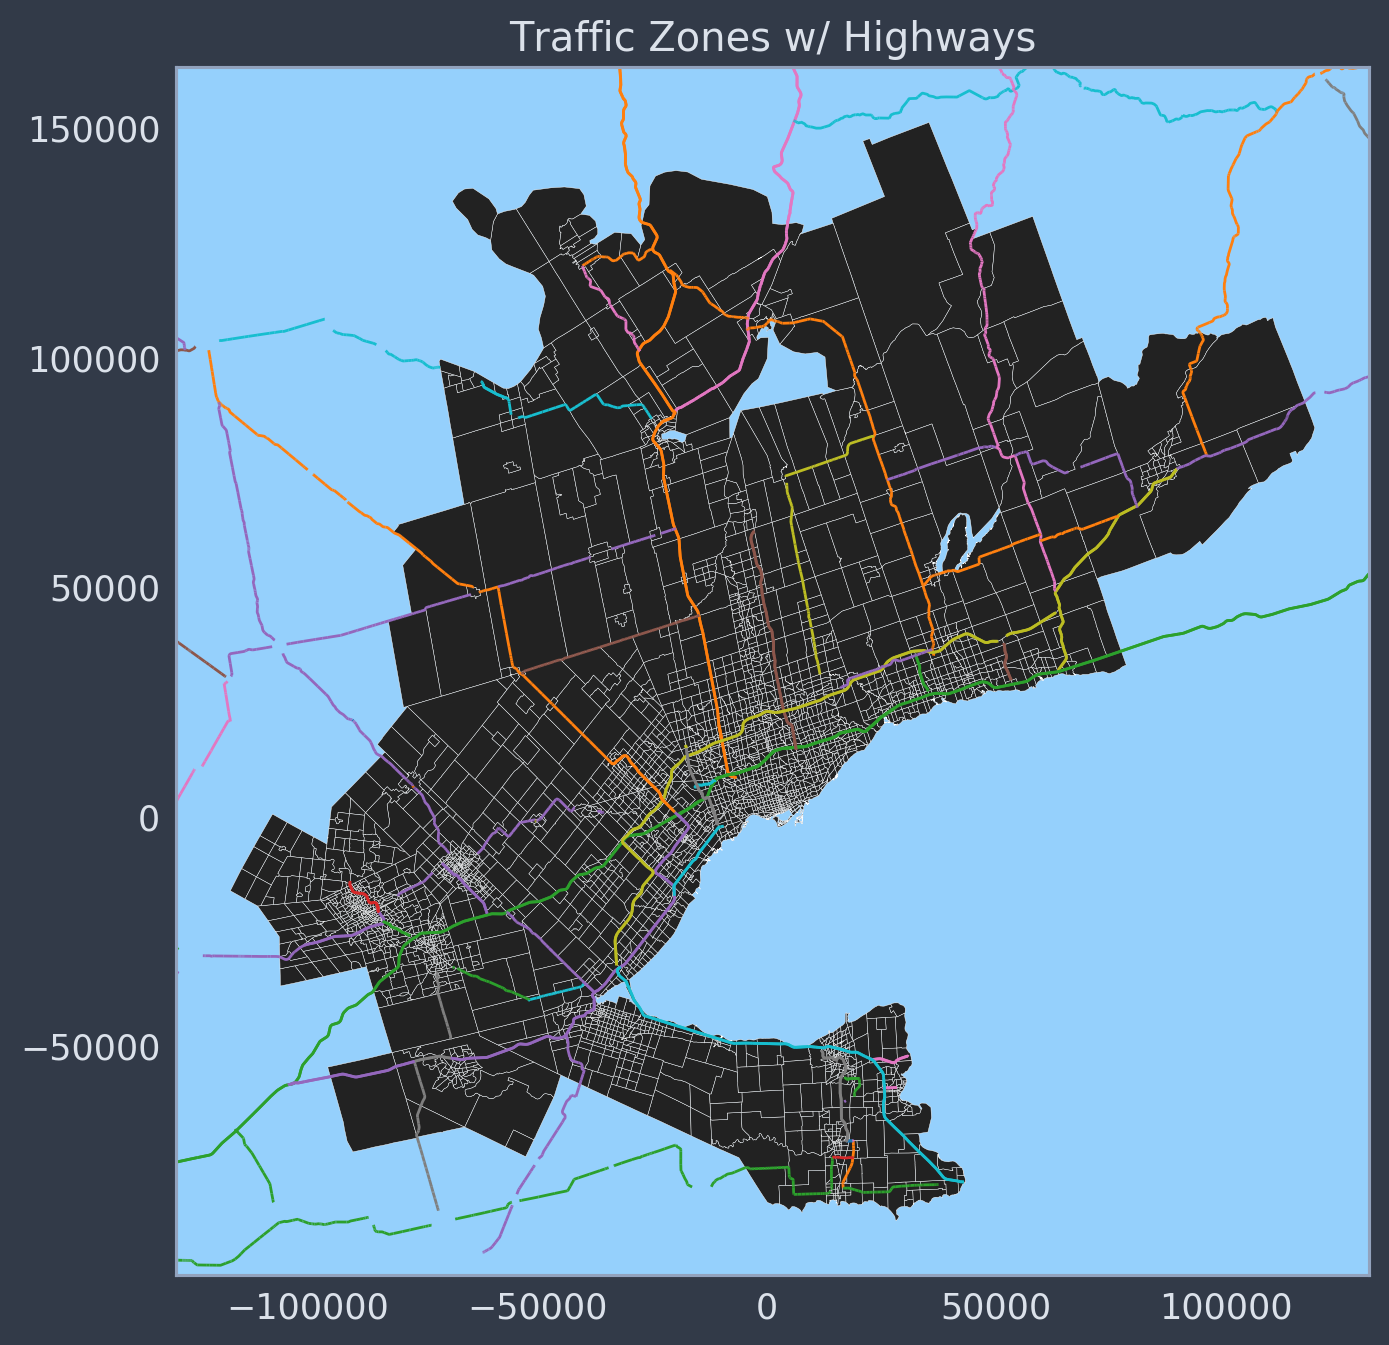

In [7]:
figure, ax = plt.subplots(dpi=200)
traffic_regions.taz_gdf.plot(ax=ax, color='k', edgecolor='w', zorder=1)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
traffic_regions.hways_gs.plot(ax=ax, linewidth=1, cmap=plt.get_cmap('tab10'))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# for _, row in pd_gdf.iterrows():
#     name = row['PD']
#     repr_point = row.geometry.representative_point()
#     plt.text(repr_point.xy[0][0], repr_point.xy[1][0], s=str(name), 
#             fontsize=8, color='w')
ax.set_facecolor('xkcd:light blue')
plt.title('Traffic Zones w/ Highways')

#### Plot Planning Districts with Highways

Text(0.5, 1, 'Planning Districts w/ Highways')

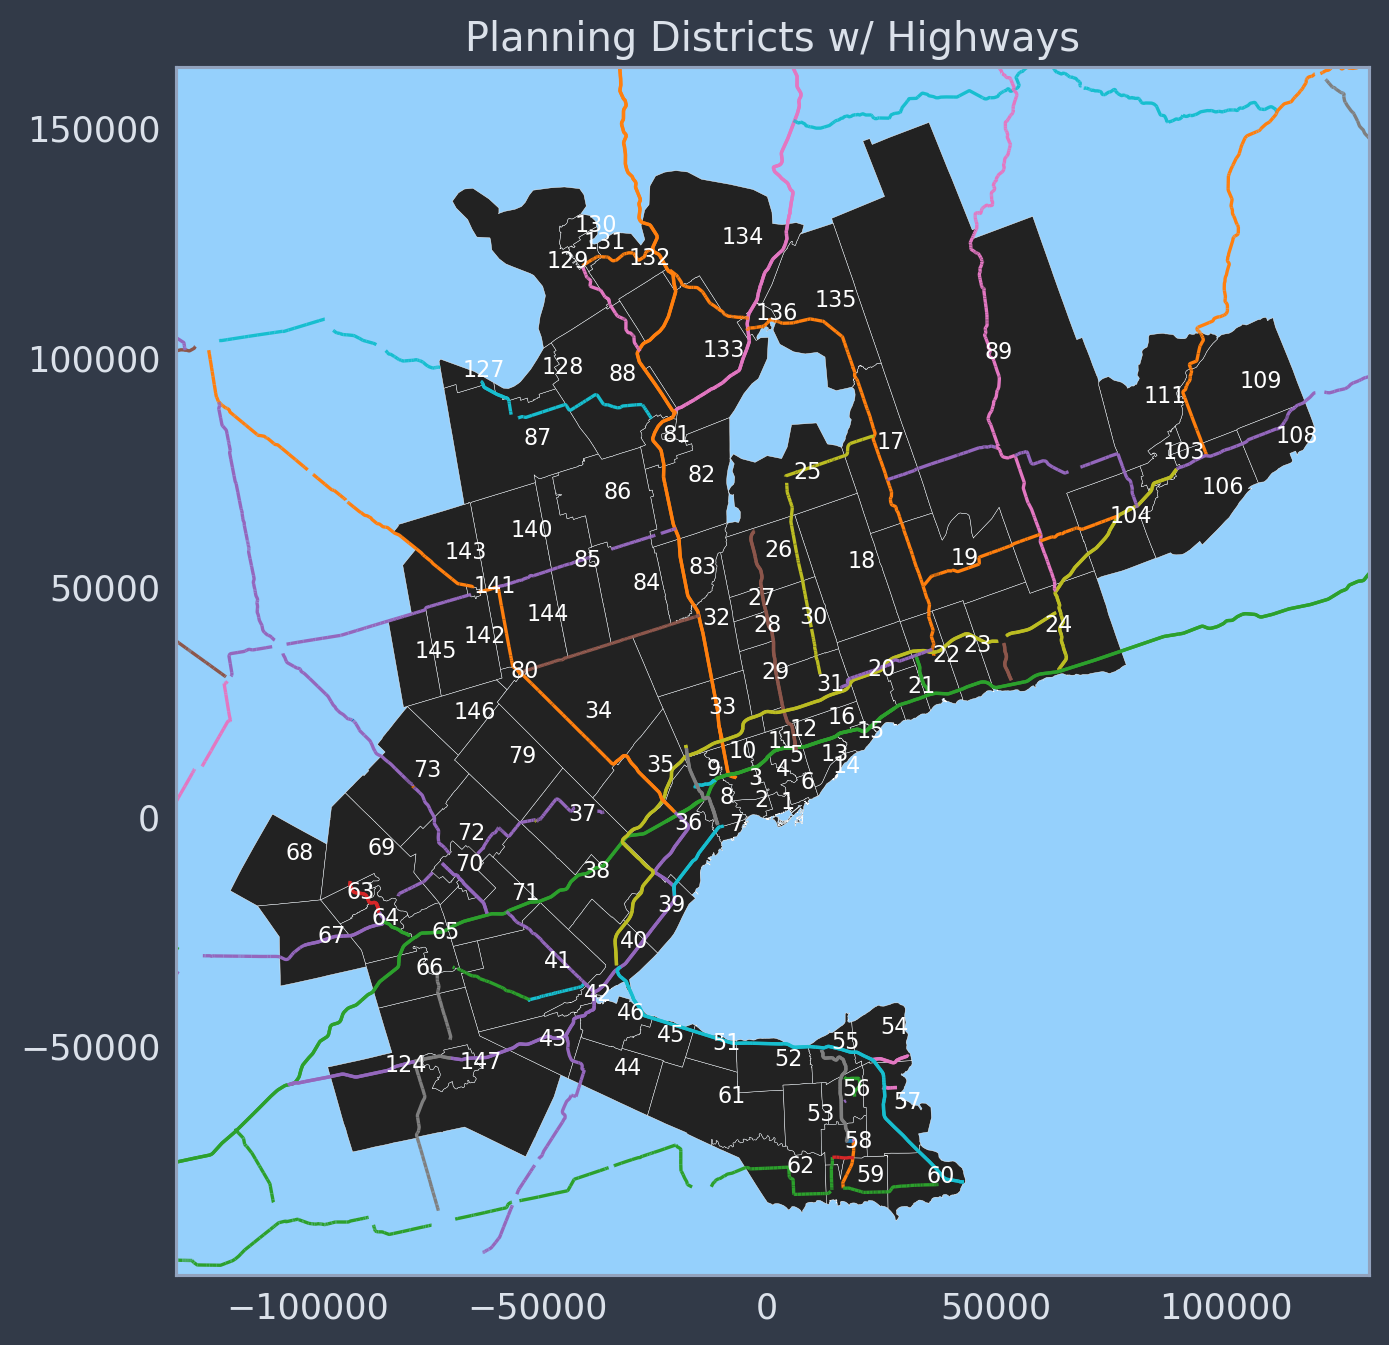

In [8]:
pd_gdf = traffic_regions.pd_gdf

figure, ax = plt.subplots(dpi=200)
pd_gdf.plot(ax=ax, color='k', edgecolor='w', zorder=1)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
traffic_regions.hways_gs.plot(ax=ax, cmap=plt.get_cmap('tab10'))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
for index, row in pd_gdf.iterrows():
    name = index 
    repr_point = row.geometry.representative_point()
    plt.text(repr_point.xy[0][0], repr_point.xy[1][0], s=str(name), 
            fontsize=8, color='w')
ax.set_facecolor('xkcd:light blue')
plt.title('Planning Districts w/ Highways')

#### Plot Regions with Highways



In [47]:
orn_gdf = gpd.read_file(orn_path)

In [60]:
hway_gdf =  orn_gdf[orn_gdf.ROAD_CLASS.isin(['Freeway', 'Expressway / Highway'])]
hway_gdf = traffic_regions.project_and_translate(hway_gdf)


In [62]:
hways = {}
for name, group in hway_gdf.groupby('ROUTE_NUMB'):
    hways[name] = unary_union(group.geometry.values)

null_route = hway_gdf[hway_gdf.ROUTE_NUMB.isna()]
for name, group in null_route.groupby('OFFICIAL_S'):
    if name in hways:
        print(name)
    else:
        hways[name] = unary_union(group.geometry.values)
# doesn't have a route_numb attribute
# gardiner = unary_union(hway_gdf[hway_gdf.OFFICIAL_S.str.contains('gardiner', regex=False, case=False)].geometry)


hways_gs = gpd.GeoSeries(hways)

Text(0.5, 1, 'Regions w/Highways')

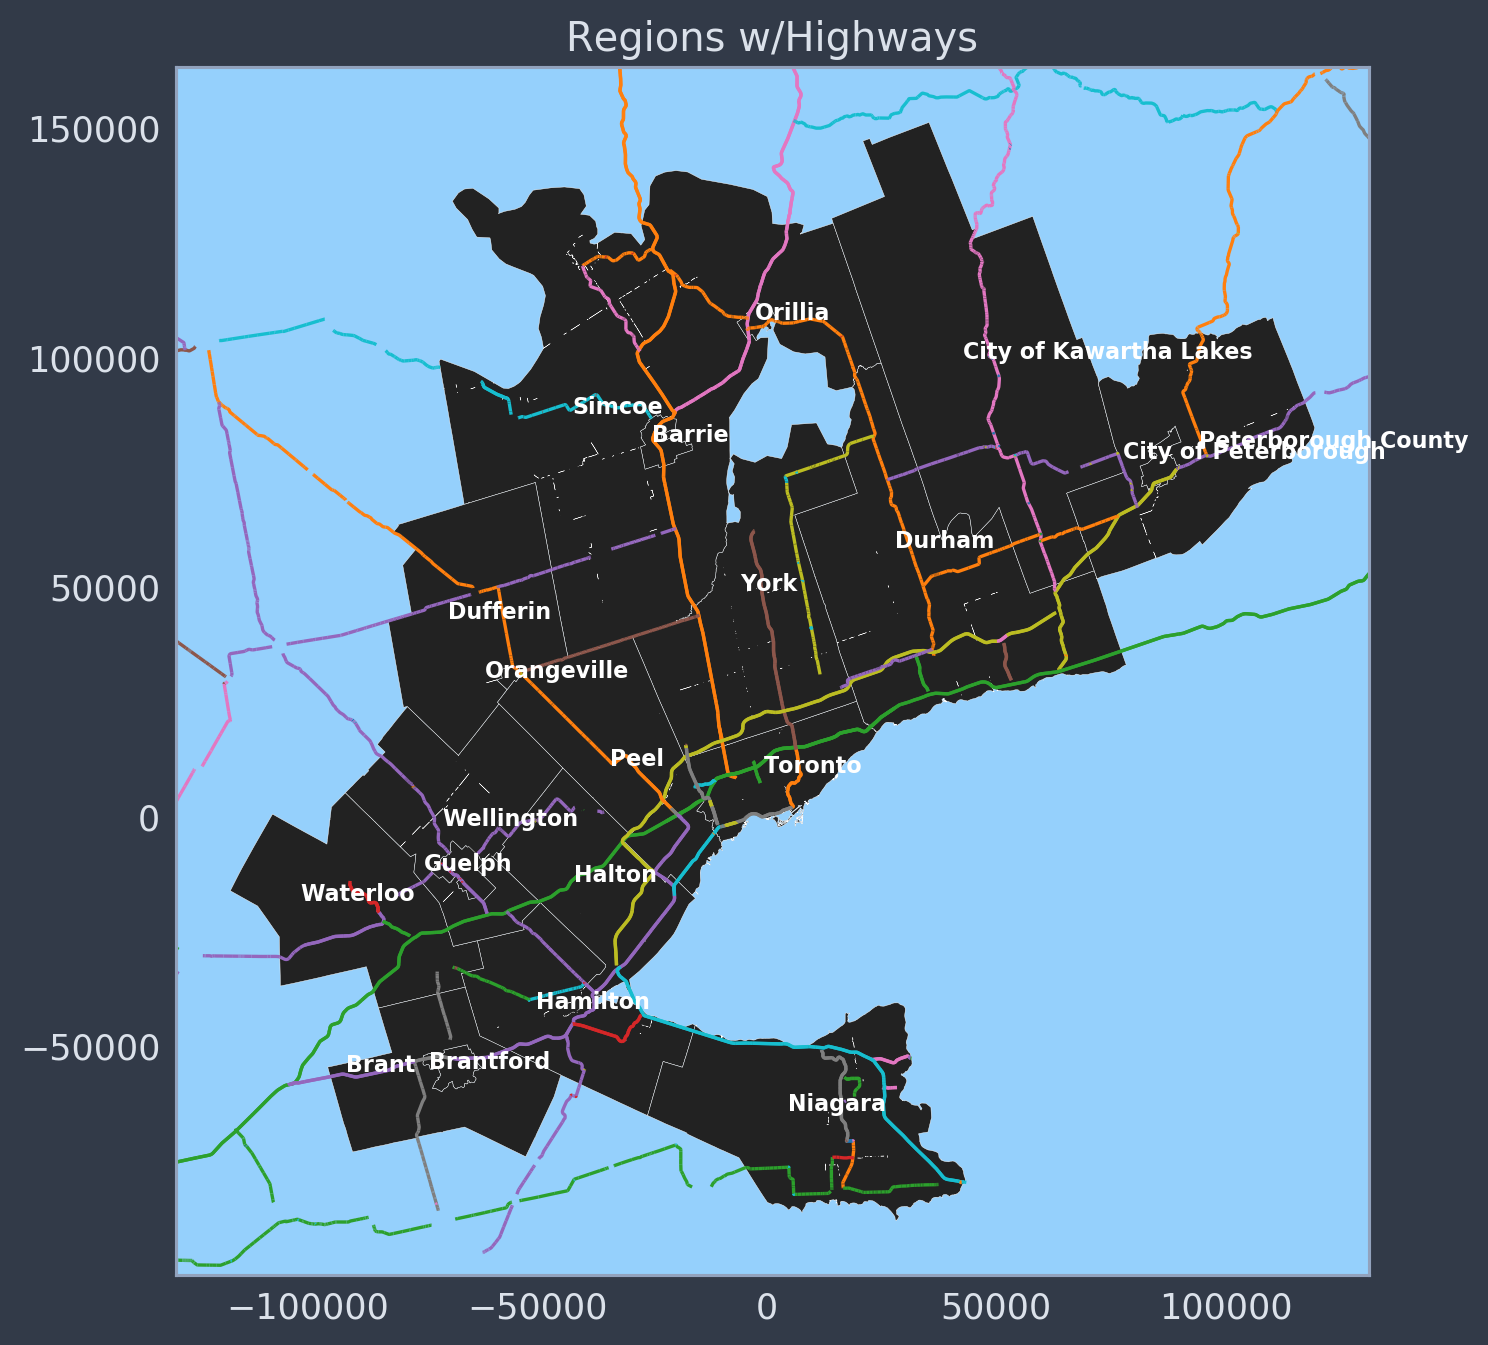

In [66]:
region_gdf = traffic_regions.region_gdf
hways_gs = traffic_regions.hways_gs

figure, ax = plt.subplots(dpi=200)
region_gdf.plot(ax=ax, color='k', edgecolor='w', zorder=1)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
hways_gs.plot(ax=ax, cmap=plt.get_cmap('tab10'))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
for _, row in region_gdf.iterrows():
    name = row.NAME
    repr_point = row.geometry.representative_point()
    x, y = repr_point.xy[0][0], repr_point.xy[1][0]
    
    plt.text(x - 0.1*abs(x), y, s=str(name), 
            fontsize=8, color='w', fontweight='bold')
ax.set_facecolor('xkcd:light blue')
plt.title('Regions w/Highways')

## Mapping regions to inflows/outflows

### Methods for determining trip types

We want to find the trip type as related to the AOI of downtown Toronto:
* interior to interior: trips that start and end in the AOI
* exterior to interior: trips that start outside AOI and terminate in AOI
* interior to exterior: trips that start inside AOI and terminate outside
* exterior to exterior: trips that start and end outside AOI

The difficulty arises in the exterior to exterior trips that may or may not travel through the AOI. To determine this, we'll use the higway network and regions

In [14]:
import networkx as nx

In [10]:
time_data_sparse = tts_data.time_data_sparse

Get the TAZ that are within the AOI

In [11]:
taz_gdf = traffic_regions.taz_gdf
intersecting_index = [sim_net.boundary_polygon.intersects(taz) for taz in taz_gdf.geometry]
taz_aoi = taz_gdf[intersecting_index]
taz_aoi = set(list(taz_aoi.GTA06))

In [72]:
traffic_regions.hways_gs.to

True